# Wrangle and Analyze Data - Gathering, Assessing and Cleaning data from Twitter

This project takes aim at gathering, assessing and cleaning data from the WeRateDogs Twitter page.

### Data Gathering and Setup
First we will setup our endpoints with Tweepy, then get data into a .csv file. We will also download a file from the internet, as well as query an API for some data, store it in a text file, and then put that data into a dataframe.

In [1]:
import tweepy
import numpy as np
import pandas as pd
import requests as rq
import json as js
import io as file
import csv

pd.set_option('max_colwidth', 100)
imagePredictionsURL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

#Downloading Tweet Image Predictions
response = rq.get(imagePredictionsURL)
with open ('tweet_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
#Reading in the Twitter archive and predictions data
twitterArchive = pd.read_csv('twitter-archive-enhanced.csv')
twitterPredictions = pd.read_csv('image_predictions.tsv', sep='\t')

#Getting more data for each Tweet ID
tweetIDs = twitterArchive.tweet_id
tweetIDs.head()

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: tweet_id, dtype: int64

In [2]:
tweet = api.get_status(892420643555336193)
tweet._json

TweepError: [{'code': 215, 'message': 'Bad Authentication data.'}]

In [5]:
#With open seems similar to using in c#. Very nice.
with open(('tweet_json.txt'), mode = 'w') as file:
    print("Getting Tweet Data..")
    for id in tweetIDs:
        try:
            tweet = api.get_status(id)
            #print('{}, {}, {}\n'.format(id, tweet.favorite_count, tweet.retweet_count))
            file.write('{}, {}, {}\n'.format(id, tweet.favorite_count, tweet.retweet_count))
        except tweepy.TweepError:
            pass
print('Done.')

Getting Tweet Data..


Rate limit reached. Sleeping for: 713
Rate limit reached. Sleeping for: 701


Done.


In [3]:
df = []
with open(('tweet_json.txt'), mode = 'r') as file:
    for line in file:
        curr = line.split(',')
        tweetID = curr[0]
        favouriteCount = curr[1]
        retweetCount = curr[2][:-1]
        df.append({'tweetID':tweetID, 'favourite_count':favouriteCount, 'retweet_count':retweetCount})

extraData = pd.DataFrame(df, columns = ['tweetID','favourite_count','retweet_count'])
extraData.head()
    

,tweetID,favourite_count,retweet_count
0,892420643555336193,37986,8302
1,892177421306343426,32613,6130
2,891815181378084864,24557,4058
3,891689557279858688,41322,8434
4,891327558926688256,39503,9147


### Data Assessment
Now we take a look at the data we've gathered and assess it for quality and tidiness issues. As a guide, below are possible issues.
##### Tidiness
- One variable per column
- One column per observation
- One table for a set of observations

##### Quality Issues
- Completeness: missing data in columns, missing rows
- Validity: data tidiness
- Accuracy: incorrect data
- Consistency: same data but store differently (format)

#### Tidiness Issues
- Multiple values in same column: https://twitter.com/dog_rates/status/882045870035918850/photo/1,https://twitter.com/dog_rates/status/882045870035918850/photo/1,https://twitter.com/dog_rates/status/882045870035918850/photo/1,https://twitter.com/dog_rates/status/882045870035918850/photo/1
- The four columns for dog classificaton (doggo, floofer etc.) can be condensed to one
- The data contained in all the dataframes are all part of one set of observations, and can be condensed into one dataframe.

#### Quality Issues
- Lots of missing data in: (1)doggo, floofer, fluffer, puppo columns. We can probably merge data from the predictions into this one.
- Expanded URL's has replicated data: https://twitter.com/dog_rates/status/888554962724278272/photo/1,https://twitter.com/dog_rates/status/888554962724278272/photo/1,https://twitter.com/dog_rates/status/888554962724278272/photo/1,https://twitter.com/dog_rates/status/888554962724278272/photo/1
- Retweets can be deleted
- Since we don't care about retweets, we don't need these columns: retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp,in_reply_to_status_id, in_reply_to_user_id
- Since we don't have predictions for posts after August 1st, 2017, remove those.
- Since the rating denominator is the same for all ratings, we can remove the rating_denominator column.
- Decimals don't seem to be handled properly. Row 342 for example, has a 9.75 rating in the text, but the integer is 75.

In [4]:
#Multiple values missing for retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls,
#in_reply_to_user_id, in_reply_to_status_id
twitterArchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
#While the extra data from the API is complete for itself, of the ID's in twitterArchive, only 1191 have data from the api. 
#That means we're missing 1165 ID's.
extraData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweetID            2340 non-null object
favourite_count    2340 non-null object
retweet_count      2340 non-null object
dtypes: object(3)
memory usage: 54.9+ KB


In [6]:
twitterArchive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,10,Franklin,None,None,None,None


In [7]:
twitterPredictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [60]:
twitterPredictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [8]:
twitterArchive.name.value_counts().head(20)

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
Cooper      11
Penny       10
Tucker      10
Lola        10
Bo           9
Winston      9
the          8
Sadie        8
Daisy        7
Buddy        7
Toby         7
Bailey       7
an           7
Leo          6
Milo         6
Name: name, dtype: int64

In [9]:
twitterArchive.rating_numerator.value_counts().head(20)

12     558
11     464
10     461
13     351
9      158
8      102
7       55
14      54
5       37
6       32
3       19
4       17
1        9
2        9
420      2
0        2
15       2
75       2
80       1
20       1
Name: rating_numerator, dtype: int64

In [10]:
twitterArchive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
twitterArchive.name.value_counts()

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Penny         10
Tucker        10
Lola          10
Bo             9
Winston        9
the            8
Sadie          8
Daisy          7
Buddy          7
Toby           7
Bailey         7
an             7
Leo            6
Milo           6
Dave           6
Scout          6
Jack           6
Stanley        6
Jax            6
Rusty          6
Bella          6
Koda           6
Oscar          6
Larry          5
            ... 
Skye           1
Emanuel        1
Jaspers        1
Harnold        1
Kevon          1
Pancake        1
Rinna          1
Strider        1
Genevieve      1
Dale           1
Bonaparte      1
William        1
Baron          1
Shiloh         1
Yukon          1
Obie           1
Shelby         1
Jerome         1
DayZ           1
Gustaf         1
Sweets         1
Eriq           1
Augie          1
Shnuggles      1
Napolean       1
Brian          1
Zeus           1
Bilbo         

### Data Cleaning

In [12]:
#Copying dataframes
copy = twitterArchive.copy()
predictions = twitterPredictions.copy()
extraCopy = extraData.copy()

<b>Define</b>: Delete retweet rows
<br>
<b>Code</b>: Delete rows that have in_reply_to_status_id values, meaning its not a retweet

In [13]:
copy.drop(copy[copy.in_reply_to_status_id.notnull()].index, inplace=True)

<b>Test</b>: There should be 0 rows for the below result

In [14]:
copy[copy.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<b>Define:</b> Remove columns that are not necessary. 
<br>
<b>Code:</b> Delete retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp,in_reply_to_status_id, in_reply_to_user_id & rating_denominator

In [15]:
copy.drop(['retweeted_status_id', 
           'retweeted_status_user_id', 
           'retweeted_status_timestamp',
           'in_reply_to_status_id', 
           'in_reply_to_user_id', 
           'rating_denominator'],  axis=1, inplace=True)

<b>Test</b>: The above columns should be deleted.

In [16]:
copy.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,Franklin,None,None,None,None


<b>Define:</b> The sources column has the entire href instead of just the source
<br>
<b>Code:</b> Clean up the sources column to only include the text.

In [17]:
copy.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2143
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [18]:
copy.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,Franklin,None,None,None,None


In [19]:
def getsource(row):
    word = ''
    if(row is not None):
        if('iPhone' in row):
            word = 'iPhone'
        if('Vine' in row):
            word = 'Vine'
        if('Web' in row):
            word = 'Web'
        if('TweetDeck' in row):
            word = 'TweetDeck'
    
    return word

copy['source'] = copy['source'].apply(lambda row: getsource(row))

<b>Test</b>: The source should only contain the actual source, and not any HTML information.

In [20]:
copy.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,Franklin,None,None,None,None


<b>Define:</b> The expanded_url's column has duplicated links
<br>
<b>Code:</b> Remove duplicated links; split on ',' and only keep the first

In [21]:
def dedupurls(row):
    url = ''
    if(row is not None):
        if(type(row) is not float):
            url = row.split(",")[0]
    return url
copy['expanded_urls'] = copy['expanded_urls'].apply(lambda row: dedupurls(row))

<b>Test</b>: There should be only one link in the expanded URL's column.

In [22]:
copy.expanded_urls.head()

0    https://twitter.com/dog_rates/status/892420643555336193/photo/1
1    https://twitter.com/dog_rates/status/892177421306343426/photo/1
2    https://twitter.com/dog_rates/status/891815181378084864/photo/1
3    https://twitter.com/dog_rates/status/891689557279858688/photo/1
4    https://twitter.com/dog_rates/status/891327558926688256/photo/1
Name: expanded_urls, dtype: object

<b>Define:</b> There are rows after August 1 that we don't need.
<br>
<b>Code:</b> Remove rows > August 1, 2017

Before this, however, we have to convert the timestamps to datetime objects.

In [23]:
copy.timestamp = pd.to_datetime(copy.timestamp)

In [24]:
copy[copy.timestamp > "2017-08-01"].index

Int64Index([0, 1], dtype='int64')

In [25]:
copy.drop(copy.index[[0,1]], inplace=True)

<b>Test</b>: There should be no rows after August 1st.

In [26]:
copy[copy.timestamp > "2017-08-01"]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo


While I understand from the feedback that the URL is supposed to be a part of the text, I don't see any advantages of it being there, especially since we already have another column with the exact same information. Now, ideally I would only keep one of these URL columns, but for the sake of this project, I'll keep both.
<br>
<b>Define:</b> There are tweet url's present in the tweet text. This isn't needed.
<br>
<b>Code:</b> Parse and remove the urls from the text, and put it into it's own column.
<br>

In [27]:
#Testing how to find text
copy.iloc[1].text.find('https:')

80

In [28]:
df2 = []
#Extract URL from tweet text and put it in it's own column.
def extracturl(row):
    if(row is not None):
        beg_index = row.find('https:')
        url = row[beg_index:]
        tweet_id = copy[copy['text'] == row]['tweet_id']
        df2.append({'tweet_id':tweet_id.iloc[0] , 'tweet_url':url})
        row = row[:beg_index]
    return row
copy['text'] = copy['text'].apply(lambda row: extracturl(row))
tweet_urls = pd.DataFrame(df2, columns = ['tweet_id','tweet_url'])

In [29]:
tweet_urls.head()

,tweet_id,tweet_url
0,891815181378084864,https://t.co/wUnZnhtVJB
1,891689557279858688,https://t.co/tD36da7qLQ
2,891327558926688256,https://t.co/AtUZn91f7f
3,891087950875897856,https://t.co/kQ04fDDRmh
4,890971913173991426,https://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl


In [30]:
#Merge the tweet_urls column into the main dataframe.
copy = pd.merge(copy, tweet_urls, on='tweet_id')

<b>Test</b>: There shouldn't be any URL's in the text column and there should be a new tweet_url column

In [31]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2276 entries, 0 to 2275
Data columns (total 12 columns):
tweet_id            2276 non-null int64
timestamp           2276 non-null datetime64[ns]
source              2276 non-null object
text                2276 non-null object
expanded_urls       2276 non-null object
rating_numerator    2276 non-null int64
name                2276 non-null object
doggo               2276 non-null object
floofer             2276 non-null object
pupper              2276 non-null object
puppo               2276 non-null object
tweet_url           2276 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 231.2+ KB


In [32]:
copy.text.iloc[1958]

"Say hello to Mark. He's a good dog. Always ready to go for a walk. Excellent posture. 9/10 keep it up Mark "

In [33]:
copy.text.iloc[1]

'This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us '

<b>Define:</b> Doggo Prediction's can be merged with this dataset
<br>
<b>Code:</b> Use the prediction dataset to put in data in the columns if the prediciton was true
<br>
We'll be transposing the #1 prediction onto the dataset, since that's the highest confidence prediction. There can be more cleaning done for this though, namely, the p1 prediction is not always true, but one of the others might be. I didn't do that here.

In [34]:
correctPredictions = twitterPredictions[twitterPredictions.p1_dog == True]
breed = correctPredictions[['tweet_id', 'p1']]
#Keeping the columns we still have.
copy = copy.merge(breed,how='left')

In [35]:
#Rename the P1 column to breed
copy = copy.rename(columns={'p1': 'breed'})
copy.shape[0]

2276

<b>Test</b>: There should be a new breed column in the dataframe.

In [36]:
copy.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo,tweet_url,breed
0,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,Archie,None,None,None,None,https://t.co/wUnZnhtVJB,Chihuahua
1,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,Darla,None,None,None,None,https://t.co/tD36da7qLQ,NaN
2,891327558926688256,2017-07-29 16:00:24,iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12,Franklin,None,None,None,None,https://t.co/AtUZn91f7f,basset
3,891087950875897856,2017-07-29 00:08:17,iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breath...,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,None,None,None,None,None,https://t.co/kQ04fDDRmh,Chesapeake_Bay_retriever
4,890971913173991426,2017-07-28 16:27:12,iPhone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more thing...,https://gofundme.com/ydvmve-surgery-for-jax,13,Jax,None,None,None,None,https://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,Appenzeller


<b>Define:</b> Dog classification columns can be reduced to one instead of 4
<br>
<b>Code:</b> Remove the four columns and replace it with one

In [37]:
classes = []
def getDoggoClass(row):
    dogClass = " "
    if(row.doggo != "None"):
        dogClass += "doggo," 
    if(row.floofer != "None"):
        dogClass += "floofer," 
    if(row.pupper != "None"):
        dogClass += "pupper," 
    if(row.puppo != "None"):
        dogClass += "puppo " 
    classes.append({'tweet_id':row.tweet_id , 'dog_class':dogClass})

#Get the classes that we do have, then merge into the main dataframe.
copy2 = copy.copy()
copy2.apply(lambda row: getDoggoClass(row), axis=1)
doggoData = pd.DataFrame(classes, columns = ['tweet_id','dog_class'])
copy2 = copy2.merge(doggoData)
#Drop the now useless columns
copy2.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

<b>Test:</b>There should be a new column for the dog classification, and the old columns should be removed

In [38]:
copy2[copy2.dog_class != " "]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,tweet_url,breed,dog_class
7,890240255349198849,2017-07-26 15:59:51,iPhone,This is Cassie. She is a college pup. Studying international doggo communication and stick theor...,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,Cassie,https://t.co/t1bfwz5S2A,Pembroke,doggo
10,889665388333682689,2017-07-25 01:55:32,iPhone,Here's a puppo that seems to be on the fence about something haha no but seriously someone help ...,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,None,https://t.co/BxvuXk0UCm,Pembroke,puppo
12,889531135344209921,2017-07-24 17:02:04,iPhone,This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 pu...,https://twitter.com/dog_rates/status/889531135344209921/photo/1,13,Stuart,https://t.co/y70o6h3isq,golden_retriever,puppo
27,886366144734445568,2017-07-15 23:25:31,iPhone,This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen i...,https://twitter.com/dog_rates/status/886366144734445568/photo/1,12,Roscoe,https://t.co/RGE08MIJox,French_bulldog,pupper
40,884162670584377345,2017-07-09 21:29:42,iPhone,Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at a...,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12,Yogi,https://t.co/YSI00BzTBZ,German_shepherd,doggo
43,883360690899218434,2017-07-07 16:22:55,iPhone,Meet Grizzwald. He may be the floofiest floofer I ever did see. Lost eyes saving a schoolbus fro...,https://twitter.com/dog_rates/status/883360690899218434/photo/1,13,Grizzwald,https://t.co/rf661IFEYP,chow,floofer
46,882762694511734784,2017-07-06 00:46:41,iPhone,This is Gus. He's quite the cheeky pupper. Already perfected the disinterested wink. 12/10 would...,https://twitter.com/dog_rates/status/882762694511734784/photo/1,12,Gus,https://t.co/D43I96SlVu,Labrador_retriever,pupper
52,881536004380872706,2017-07-02 15:32:16,iPhone,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-i...,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,a,https://t.co/ghXBIIeQZF,Samoyed,pupper
66,878776093423087618,2017-06-25 00:45:22,iPhone,This is Snoopy. He's a proud #PrideMonthPuppo. Impeccable handwriting for not having thumbs. 13/...,https://twitter.com/dog_rates/status/878776093423087618/photo/1,13,Snoopy,https://t.co/lNZwgNO4gS,Italian_greyhound,puppo
73,877611172832227328,2017-06-21 19:36:23,iPhone,RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10,https://twitter.com/rachel2195/status/876850772322988033/photo/1,14,None,https://t.co/dJx4Gzc50G,Irish_setter,pupper


In [39]:
copy = copy2

<b>Define:</b> Not all the dogs are classified
<br>
<b>Code:</b> Try to find classifications from the tweet text and set it for the classification column. If not present, then no problem.

In [40]:
copy.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,tweet_url,breed,dog_class
0,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,Archie,https://t.co/wUnZnhtVJB,Chihuahua,
1,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,Darla,https://t.co/tD36da7qLQ,NaN,
2,891327558926688256,2017-07-29 16:00:24,iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12,Franklin,https://t.co/AtUZn91f7f,basset,
3,891087950875897856,2017-07-29 00:08:17,iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breath...,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,None,https://t.co/kQ04fDDRmh,Chesapeake_Bay_retriever,
4,890971913173991426,2017-07-28 16:27:12,iPhone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more thing...,https://gofundme.com/ydvmve-surgery-for-jax,13,Jax,https://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,Appenzeller,


In [41]:
copy2 = copy.copy()
finalClasses = []
count = 0
shouldInc = False

def getClassFromText(row):
    global shouldInc
    global count
    res = "NaN"
    if(row is not None):
        if(("None" in row.dog_class) or (" " == row.dog_class)):            
            if("doggo" in row.text):
                res = "doggo "
                shouldInc = True
            if("floofer" in row.text):
                res += "floofer "
                shouldInc = True
            if("pupper" in row.text):
                res += "pupper "
                shouldInc = True
            if("puppo" in row.text):
                res += "puppo"
                shouldInc = True
        else:
            res = row.dog_class
    if(shouldInc):
        count += 1
        shouldInc = False
    finalClasses.append({'tweet_id':row.tweet_id , 'dog_class':res})

copy2.apply(lambda row: getClassFromText(row), axis=1)
finalClassData = pd.DataFrame(classes, columns = ['tweet_id','dog_class'])


<b>Test:</b> Check to see if we found any new values

In [42]:
print(count)

38


In [43]:
#38 new dog classification values. Not bad. Merging that into copy2:
copy2.merge(finalClassData, how="left")
copy = copy2


<b>Define:</b> A lot of the names are set to "a", because of what I think is the way the names were gotten. The process probably looked at the text and took the word that came after "this is..". And a lot of these sentences end up being "this is a..." which makes the process think the name is "a"
<br>
<b>Code:</b> Instead of using "this is.." as the precursor, use "named.." (and other such words that indicate that th enext word is a Name) and get the word after that. We will atleast get a few more names.

In [44]:
copy.name.value_counts().head(20)

None       668
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Lola        10
Tucker      10
Penny       10
Winston      9
Bo           9
the          8
Sadie        8
Buddy        7
Bailey       7
an           7
Daisy        7
Toby         7
Koda         6
Milo         6
Name: name, dtype: int64

In [45]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2276 entries, 0 to 2275
Data columns (total 10 columns):
tweet_id            2276 non-null int64
timestamp           2276 non-null datetime64[ns]
source              2276 non-null object
text                2276 non-null object
expanded_urls       2276 non-null object
rating_numerator    2276 non-null int64
name                2276 non-null object
tweet_url           2276 non-null object
breed               1517 non-null object
dog_class           2276 non-null object
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 195.6+ KB


In [46]:
finalClasses = []
def getName(ads):
    #Question: Why did I have to treat ads as an array? I didn't have to do this in earlier funtions, I could just do 
    #ads.name or ads.text. This was the part that I was unable to work out in the previous submission, but figured out now.
    text = ads[3]
    name = ads[6]
    if(("None" in name) or ("a" == name) or ("the" in name) or ("such" in name)or ("an" == name)):
        if("named" in text):
            substring = text[text.find("named") + 5:].split('.')[0]
            finalClasses.append({'tweet_id':ads[0] , 'name':substring})
        elif("Meet" in text):
            substring = text[text.find("Meet") + 4:].split('.')[0]
            finalClasses.append({'tweet_id':ads[0] , 'name':substring})
            
copy2.apply(lambda ads: getName(ads), axis=1)
missingNames = pd.DataFrame(finalClasses, columns = ['tweet_id','name'])

In [47]:
#seeing how many new names we found.
missingNames.shape[0]

24

In [48]:
missingNames

,tweet_id,name
0,798628517273620480,Tickles
1,675706639471788032,Wylie
2,673636718965334016,Kip
3,671743150407421952,Jacob (Yacōb)
4,671147085991960577,Rufus
5,670427002554466305,Spork
6,670361874861563904,Cherokee
7,670303360680108032,Hemry
8,669923323644657664,Alphred
9,669564461267722241,Alfredo


In [49]:
copy2 = copy2.merge(missingNames, how="left")

In [50]:
#Checking to see if there are names we might have missed based on this algorithm
copy2[copy2.name == "None"].text

3       Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breath...
5       When you watch your owner call another dog a good boy but then they turn back to you and say you...
10      Here's a puppo that seems to be on the fence about something haha no but seriously someone help ...
22                You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) 
23      This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you....
29                                                                              RT @Athletics: 12/10 #BATP 
32                                                         I have a new hero and his name is Howard. 14/10 
34      Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero...
38      I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compac...
39      OMG HE DIDN'T MEAN T

In [51]:
#Looks like there are no names (that we can see) in the text for the remaining no-name dogs.
copy = copy2

<b>Define:</b> Some rows have floats for the rating, which is not handled correctly
<br>
<b>Code:</b> Find which rows have this issue, and fix them manually (there are only a few)

In [52]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
copy[copy.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\Dhruv\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,tweet_url,breed,dog_class
42,883482846933004288,2017-07-08 00:28:19,iPhone,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",https://twitter.com/dog_rates/status/883482846933004288/photo/1,5,Bella,https://t.co/qjrljjt948,golden_retriever,
319,832215909146226688,2017-02-16 13:11:49,iPhone,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,Logan,https://t.co/yBO5wu…,NaN,
663,786709082849828864,2016-10-13 23:23:56,iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,Logan,https://t.co/yBO5wuqaPS,Pomeranian,
730,778027034220126208,2016-09-20 00:24:34,iPhone,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,Sophie,https://t.co/QFaUiIHxHq,clumber,pupper
1651,680494726643068929,2015-12-25 21:06:00,iPhone,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,None,https://t.co/eNm2S6p9BD,kuvasz,


In [53]:
#Note on my method: Here, I am just rounding up or rounding down the numbers. I could have also converted the column 
#to float, and put the precise number in there as well.
copy2 = copy.copy()
copy2.iloc[42, copy2.columns.get_loc('rating_numerator')] = 13
copy2.iloc[319, copy2.columns.get_loc('rating_numerator')] = 10
copy2.iloc[663, copy2.columns.get_loc('rating_numerator')] = 10
copy2.iloc[730, copy2.columns.get_loc('rating_numerator')] = 11
copy2.iloc[1651, copy2.columns.get_loc('rating_numerator')] = 11

In [54]:
#To prove that converting the column into a float will also work, here's the code for that:
copyFloat = copy.copy()
copyFloat.rating_numerator.astype(float)

copyFloat.iloc[42, copyFloat.columns.get_loc('rating_numerator')] = 13.5
copyFloat.iloc[319, copyFloat.columns.get_loc('rating_numerator')] = 9.75
copyFloat.iloc[663, copyFloat.columns.get_loc('rating_numerator')] = 9.75
copyFloat.iloc[730, copyFloat.columns.get_loc('rating_numerator')] = 11.27
copyFloat.iloc[1651, copyFloat.columns.get_loc('rating_numerator')] = 11.26


<b>Test:</b> The values should now show up correctly.

In [55]:
copy2[copy2.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\Dhruv\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,tweet_url,breed,dog_class
42,883482846933004288,2017-07-08 00:28:19,iPhone,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",https://twitter.com/dog_rates/status/883482846933004288/photo/1,13,Bella,https://t.co/qjrljjt948,golden_retriever,
319,832215909146226688,2017-02-16 13:11:49,iPhone,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",https://twitter.com/dog_rates/status/786709082849828864/photo/1,10,Logan,https://t.co/yBO5wu…,NaN,
663,786709082849828864,2016-10-13 23:23:56,iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",https://twitter.com/dog_rates/status/786709082849828864/photo/1,10,Logan,https://t.co/yBO5wuqaPS,Pomeranian,
730,778027034220126208,2016-09-20 00:24:34,iPhone,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11,Sophie,https://t.co/QFaUiIHxHq,clumber,pupper
1651,680494726643068929,2015-12-25 21:06:00,iPhone,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11,None,https://t.co/eNm2S6p9BD,kuvasz,


In [56]:
copyFloat[copyFloat.text.str.contains(r"(\d+\.\d*\/\d+)")]

C:\Users\Dhruv\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if __name__ == '__main__':


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,tweet_url,breed,dog_class
42,883482846933004288,2017-07-08 00:28:19,iPhone,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",https://twitter.com/dog_rates/status/883482846933004288/photo/1,13.50,Bella,https://t.co/qjrljjt948,golden_retriever,
319,832215909146226688,2017-02-16 13:11:49,iPhone,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",https://twitter.com/dog_rates/status/786709082849828864/photo/1,9.75,Logan,https://t.co/yBO5wu…,NaN,
663,786709082849828864,2016-10-13 23:23:56,iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",https://twitter.com/dog_rates/status/786709082849828864/photo/1,9.75,Logan,https://t.co/yBO5wuqaPS,Pomeranian,
730,778027034220126208,2016-09-20 00:24:34,iPhone,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11.27,Sophie,https://t.co/QFaUiIHxHq,clumber,pupper
1651,680494726643068929,2015-12-25 21:06:00,iPhone,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11.26,None,https://t.co/eNm2S6p9BD,kuvasz,


In [57]:
copyFloat.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,tweet_url,breed,dog_class
0,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,Archie,https://t.co/wUnZnhtVJB,Chihuahua,
1,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,Darla,https://t.co/tD36da7qLQ,NaN,
2,891327558926688256,2017-07-29 16:00:24,iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek",https://twitter.com/dog_rates/status/891327558926688256/photo/1,12.0,Franklin,https://t.co/AtUZn91f7f,basset,
3,891087950875897856,2017-07-29 00:08:17,iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,None,https://t.co/kQ04fDDRmh,Chesapeake_Bay_retriever,
4,890971913173991426,2017-07-28 16:27:12,iPhone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\n,https://gofundme.com/ydvmve-surgery-for-jax,13.0,Jax,https://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,Appenzeller,


In [58]:
copy = copyFloat

In [59]:
#save final
copy.to_csv("twitter_archive_master.csv", encoding='utf-8', index=False)

#### Analysis
Note: This analysis is replicated exactly in the act_report.pdf file, because the project asks to include insights and visualizations for this document as well as a separate document (act_report.pdf), so I just put this in both.
What follows is some basic, preliminary analysis on the now clean data. 

In [292]:
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt

iPhones are popular, we all know that. Take a random sample from anywhere and you'll most probably find suggestive results - this dataset is no different. iPhones represent the vast majority of twitter users in this group. 

In [293]:
copy.source.value_counts()

iPhone       2141
Vine           91
Web            33
TweetDeck      11
Name: source, dtype: int64

In [294]:
copy2 = copy.copy()

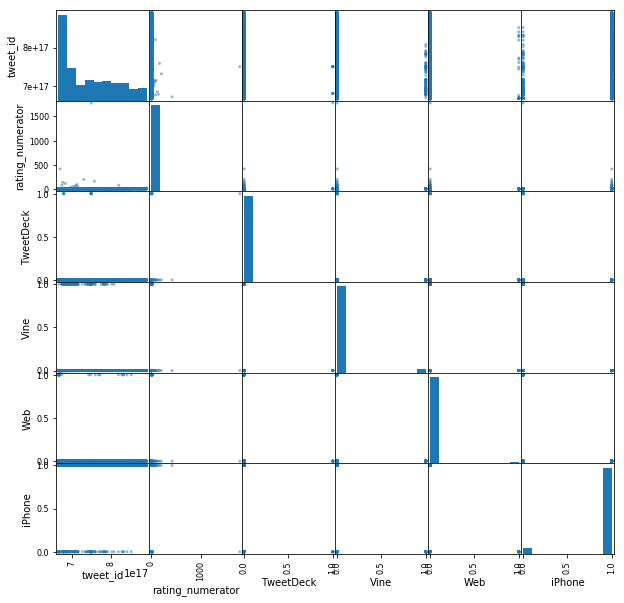

In [295]:
dummies = pd.get_dummies(copy2.source)
copy2[['TweetDeck','Vine','Web','iPhone']] = dummies
pd.plotting.scatter_matrix(copy2,figsize=(10, 10));

However,there doesn't seem to be any positive correlation between whether certain sources tend to have higher ratings - which should be the case just through sheer numbers that having an iPhone corresponds to a higher score; but this doesn't happen.

In [296]:
copy2 = copy.copy()
copy2.source.value_counts()

iPhone       2141
Vine           91
Web            33
TweetDeck      11
Name: source, dtype: int64

In [297]:
copy2.groupby('source').rating_numerator.mean()

source
TweetDeck    171.545455
Vine          11.395604
Web           10.121212
iPhone        11.353354
Name: rating_numerator, dtype: float64

In [298]:
copy2 = copy2[copy2.rating_numerator <= 15]
copy2.groupby('source').rating_numerator.mean()

source
TweetDeck    11.100000
Vine         11.395604
Web          10.121212
iPhone       10.662685
Name: rating_numerator, dtype: float64

In [299]:
copy2.rating_numerator.mean()

10.686214064573198

What are the most common breeds, you might ask? If you are ever on the internet, then you'd wager that golden retreivers would be somewhere up there. We can all agree that this breed is over-represented due to it's popularity - and the data describes this well. Goldies and Labradoes are among the top five, and not far behind are Chihuahuas and Pugs.


Text(0, 0.5, 'Breed')

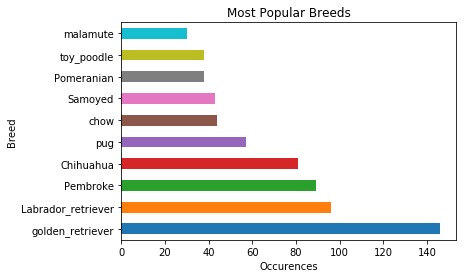

In [300]:
copy2['breed'].value_counts().head(10).plot(kind='barh')
plt.title('Most Popular Breeds')
plt.xlabel('Occurences')
plt.ylabel('Breed')

Text(0, 0.5, 'Breed')

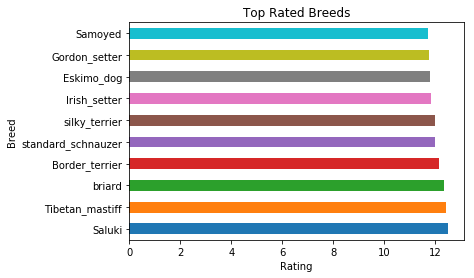

In [301]:
copy2.groupby('breed').rating_numerator.mean().sort_values(ascending=False).head(10).plot(kind="barh")
plt.title('Top Rated Breeds')
plt.xlabel('Rating')
plt.ylabel('Breed')

Another thing we can check is what are the most common doggo stages tweeted.

In [302]:
dogClasses = copy2[copy2['dog_class'] != "NaN"]['dog_class'].value_counts()[1:6] #removing some values that have only 1 occurence
dogClasses

 pupper           242
 doggo             80
 puppo             28
 doggo pupper      11
 floofer            9
Name: dog_class, dtype: int64

Text(0.5, 1.0, 'Most Common Dog Stages')

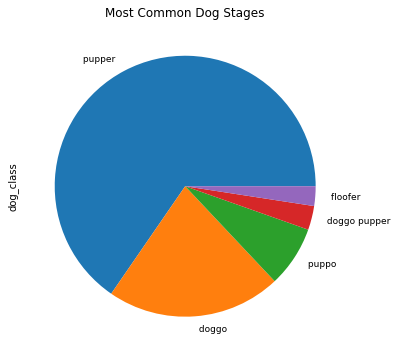

In [303]:
explode = (0,0,0.1,0.2,0.2,0.4, 0.5, 0.5)
dogClasses.plot(kind='pie', figsize=(6, 6), fontsize=9)
plt.title('Most Common Dog Stages')
#plt.legend(loc='none')